In [1]:
import os
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.empty_cache()

In [2]:
from data import SpectraDataset
from model import CVAE, load_model

In [3]:
working_dir = os.getcwd()+'/'
model_dir = working_dir+"trial_0/"
spectra_dataset = SpectraDataset(working_dir=working_dir)
state = torch.load(model_dir+"model.pt", map_location=device)
model = CVAE(**state['model_init']).to(device)

In [4]:
spectra_dataset.load_and_normalize_data(data_dir=working_dir,limit=None,
                                        fname_x="X.h5",fname_y="Y.h5")
print(spectra_dataset.X_norm.shape, spectra_dataset.y_norm.shape)

(1000, 128, 64) (1000, 9)


In [5]:
# req_pars = {"eps_e":0.001,"eps_b":0.01,"eps_t":1.,"p":2.2,
#             "theta_obs":0.,"n_ism":1e0, "freq":spectra_dataset.freqs[0]}
# y_vec = [np.float32(req_pars[feat]) for feat in spectra_dataset.feature_names]
def inference(y_vec, model, spectra_dataset):
    
    y_vec = np.asarray(y_vec).reshape(1, -1)
    # normalize parameters as in the training data
    y_vec_norm = spectra_dataset.transform_y(y_vec)
    # generate prediction
    with torch.no_grad():
        # convert intput data to the format of the hidden space
        z = (torch.zeros((1, model.latent_size)).repeat((len(y_vec_norm), 1)).to(device).to(torch.float))
        c = torch.from_numpy(y_vec_norm).to(device).to(torch.float)
        # create the input for the decoder
        # decoder_input = torch.cat((z, torch.from_numpy(y_vec_norm).to(device).to(torch.float)), dim=1)
        # perform reconstruction using model
        reconstructions = model.decode(z, c)
    # move prediction to cpu and numpy
    reconstructions_np = reconstructions.double().cpu().detach().numpy()
    # undo normalization that was done in training data
    spectra_nn = spectra_dataset.inverse_transform_X(reconstructions_np)
    spectra_nn = np.reshape(spectra_nn, newshape=(spectra_dataset.X_norm.shape[1], 
                                                  spectra_dataset.X_norm.shape[2]))    
    print(spectra_nn.shape)
    return spectra_nn
spectra_nn = inference(y_vec = spectra_dataset.y_norm[0,:],
                       model=model, spectra_dataset=spectra_dataset)

(128, 64)


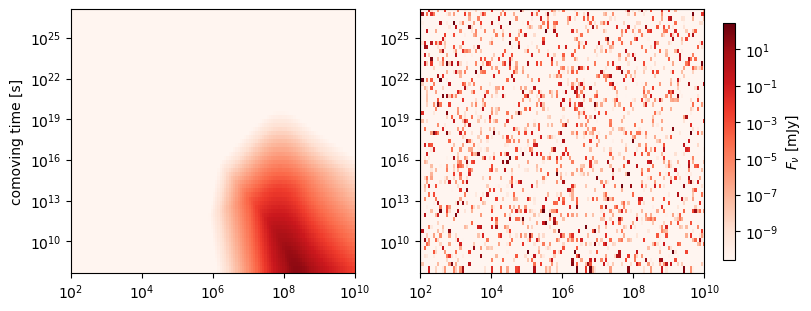

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize
def compare_spectra(times, freqs, spectra, spectra_nn):
    fig, axes = plt.subplots(ncols=2, nrows=1, #sharex="n", sharey="row", 
                             figsize=(8, 3),
                             # gridspec_kw=dict(height_ratios=[1.2, 1.2]),
                             layout='constrained')
    # ax = axes[0, 0] # lcs
    # ax = axes[0, 1] # spectra
    
    
    ax = axes[0]#[1, 0]  # [1, 1]  # row,col
    spectra[~np.isfinite(spectra)] = 1e-100
    # spectra = spectra * freqs[np.newaxis, :]
    norm = LogNorm(vmin=spectra.max() * 1e-12, vmax=spectra.max() * 10)
    _c = ax.pcolormesh(times, freqs, spectra.T, cmap='Reds', norm=norm)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r'comoving time [s]')
    # ax.set_xlabel(r'$\nu$ [Hz]')
    ax.set_xlim(times[0], times[-1])

    ax = axes[1]#[1, 1]  # [1, 1]  # row,col
    spectra_nn[~np.isfinite(spectra_nn)] = 1e-100
    # spectra_nn = spectra_nn * freqs[np.newaxis, :]
    # norm = LogNorm(vmin=emissivitty2.max() * 1e-5, vmax=emissivitty2.max())
    _c = ax.pcolormesh(times, freqs, spectra_nn.T, cmap='Reds', norm=norm)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylabel(r'comoving time [s]')
    # ax.set_xlabel(r'$\nu$ [Hz]')
    ax.set_xlim(times[0], times[-1])
    fig.colorbar(_c, ax=ax, shrink=0.9, pad=.01, label=r'$F_{\nu}$ [mJy]')
    plt.show()
compare_spectra(spectra_dataset.times,spectra_dataset.freqs,spectra_dataset.X[0],
                spectra_nn)